In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import os

path_v0  = '.\\V_0'
path_v1  = '.\\V_1'

V0 = {}

V1 = {}

In [3]:
import zlib
def carregar_conteudo_npy(caminho_arquivo):
    with open(caminho_arquivo, 'rb') as compressed_file:
        compressed_data = compressed_file.read()

        decompressed_data = zlib.decompress(compressed_data)

        decompressed_array = np.frombuffer(decompressed_data, dtype=np.float64)

        canal1 = decompressed_array[::2]
        canal2 = decompressed_array[1::2]

        data = {
            'Canal 1': canal1,
            'Canal 2': canal2
        }

        df = pd.DataFrame(data)

        return df

In [4]:
def encontrar_arquivo_npy(caminho_pasta):
    for arquivo in os.listdir(caminho_pasta):
        if arquivo.endswith('.npy'):
            return os.path.join(caminho_pasta, arquivo)
    return None

In [5]:
numeros = [str(n).zfill(2) for n in range(1, 10, 1)]

In [6]:
for numero in numeros:
    nome_pasta = f'S_02_{numero}'
    caminho_pasta = os.path.join(path_v0, nome_pasta)
    caminho_arquivo = encontrar_arquivo_npy(caminho_pasta)
    if caminho_arquivo:
        V0[numero] = carregar_conteudo_npy(caminho_arquivo)

Descomprimindo arquivo .\V_0\S_02_01\dados_linux_compressed_2023-11-13_10-34-43.npy
Descomprimindo arquivo .\V_0\S_02_02\dados_linux_compressed_2023-11-13_10-36-43.npy
Descomprimindo arquivo .\V_0\S_02_03\dados_linux_compressed_2023-11-13_10-35-39.npy
Descomprimindo arquivo .\V_0\S_02_04\dados_linux_compressed_2023-11-13_10-37-40.npy
Descomprimindo arquivo .\V_0\S_02_05\dados_linux_compressed_2023-11-13_10-40-22.npy
Descomprimindo arquivo .\V_0\S_02_06\dados_linux_compressed_2023-11-13_10-41-21.npy
Descomprimindo arquivo .\V_0\S_02_07\dados_linux_compressed_2023-11-13_10-46-53.npy
Descomprimindo arquivo .\V_0\S_02_08\dados_linux_compressed_2023-11-13_10-45-59.npy
Descomprimindo arquivo .\V_0\S_02_09\dados_linux_compressed_2023-11-13_10-47-50.npy


In [7]:
# o mesmo para V_1
for numero in numeros:
    nome_pasta = f'S_02_{numero}'
    caminho_pasta = os.path.join(path_v1, nome_pasta)
    caminho_arquivo = encontrar_arquivo_npy(caminho_pasta)
    if caminho_arquivo:
        V1[numero] = carregar_conteudo_npy(caminho_arquivo)

Descomprimindo arquivo .\V_1\S_02_01\dados_linux_compressed_2023-11-13_14-16-41.npy
Descomprimindo arquivo .\V_1\S_02_02\dados_linux_compressed_2023-11-13_14-17-22.npy
Descomprimindo arquivo .\V_1\S_02_03\dados_linux_compressed_2023-11-13_14-18-19.npy
Descomprimindo arquivo .\V_1\S_02_04\dados_linux_compressed_2023-11-13_14-19-03.npy
Descomprimindo arquivo .\V_1\S_02_05\dados_linux_compressed_2023-11-13_14-19-50.npy
Descomprimindo arquivo .\V_1\S_02_06\dados_linux_compressed_2023-11-13_14-20-41.npy
Descomprimindo arquivo .\V_1\S_02_07\dados_linux_compressed_2023-11-13_14-22-05.npy
Descomprimindo arquivo .\V_1\S_02_08\dados_linux_compressed_2023-11-13_14-22-48.npy
Descomprimindo arquivo .\V_1\S_02_09\dados_linux_compressed_2023-11-13_14-23-40.npy


In [9]:
V0['05']

Canal 1   Canal 2
0       -0.024138 -0.019698
1       -0.016803 -0.023448
2       -0.013136 -0.027197
3       -0.005802 -0.023448
4       -0.013136 -0.023448
...           ...       ...
9999995 -0.005802 -0.019698
9999996 -0.005802 -0.019698
9999997 -0.013136 -0.019698
9999998 -0.016803 -0.023448
9999999 -0.016803 -0.019698

[10000000 rows x 2 columns]

### Faz a FFT

In [9]:
fs = 1000000.0
N = 10000000
T = 1.0 / fs

In [10]:
from scipy.fft import fft, fftfreq

def FFT( df, canal, fs, N ):
    T = 1/fs
    x = np.linspace(0.0, N*T, N, endpoint=False)
    y = df[canal].values

    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    yf = 2.0/N * np.abs(yf[:N//2])

    return xf, yf

In [11]:
xf_fft_v1, yf_canal_1 = FFT(V1['07'], 'Canal 1', fs, N)
_, yf_canal_2 = FFT(V1['07'], 'Canal 2', fs, N)

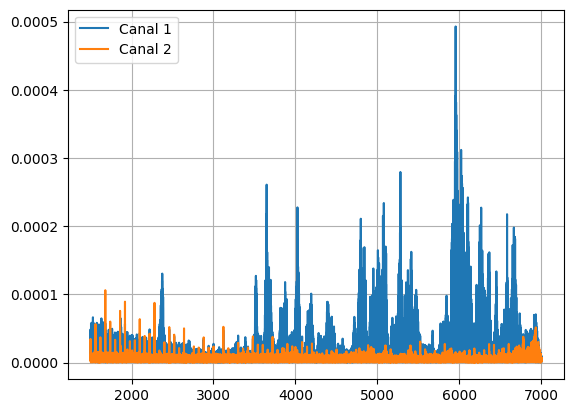

In [12]:
import matplotlib.pyplot as plt

intervalo_subamostragem = 1

offset_1 = 15000
freq_final = 70000

subsampling_index = np.arange(offset_1, freq_final, intervalo_subamostragem)

xf_subset = xf_fft_v1[subsampling_index]
yf_subset_1 = yf_canal_1[subsampling_index]
yf_subset_2 = yf_canal_2[subsampling_index]

plt.plot(xf_subset, yf_subset_1, label='Canal 1')
plt.plot(xf_subset, yf_subset_2, label='Canal 2')
plt.legend()
plt.grid()
plt.show()

### Aqui, por visualização, optou-se por utilizar um filtro butterworth passa-faixa com F0_baixa = 15kHz e F0_alta = 75kHz. A FFT vai ser aplicada sobre janelas de 0.1s de dados

In [13]:
def sliding_window(data, window_size):
    windows = []
    for i in range(0, len(data), window_size):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [14]:
window_size = 10000 # 0.01 s of data

keep_percentage_v1 = 1
if keep_percentage_v1 < 0.1:
    raise "Choose at least 10%"
keep_percentage_v0 = keep_percentage_v1/9

new_size = 2500
does_downsample = True

if does_downsample == False:
    print("No downsample")
    new_size = window_size

In [15]:
V0_windows = {key: sliding_window(df, window_size) for key, df in V0.items()}
V1_windows = {key: sliding_window(df, window_size) for key, df in V1.items()}

In [16]:
len(V0_windows['01'])

1000

In [21]:
len(V0_windows['01'][0])

10000

In [17]:
def downsample_dataframe(df, new_size):
    downsample_factor = len(df) // new_size
    
    downsampled_df = df.iloc[::downsample_factor]
    
    return downsampled_df

In [18]:
if does_downsample == True:
    for key, value in V0_windows.items():
        for i, df in enumerate(value):
            V0_windows[key][i] = downsample_dataframe(df, new_size)

In [19]:
len(V0_windows)

9

In [20]:
len(V0_windows['01'])

1000

In [21]:
len(V0_windows['01'][0])

2500

In [22]:
for key, value_list in V0_windows.items():
    for i, df in enumerate(value_list):
        V0_windows[key][i] = V0_windows[key][i].reset_index(drop=True)

### Optou-se por dropar dados de normalidade pela semelhança entre eles, com principal objetivo de reduzir custo computacional para treinar o modelo final

In [23]:
import random

for key, value in V0_windows.items():
    num_to_keep =int(len(value) * keep_percentage_v0)
    
    indices_to_keep = random.sample(range(len(value)), num_to_keep)
    
    V0_windows[key] = [value[i] for i in indices_to_keep]

In [32]:
len(V0_windows)

9

In [33]:
len(V0_windows['01'])

111

In [34]:
len(V0_windows['06'][0])

2500

### Optou-se por reduzir a quantidade de dados de cada classe para que a GPU não sofra com problemas de memória

In [35]:
len(V1_windows['01'][0])

10000

In [24]:
if does_downsample == True:
    for key, value in V1_windows.items():
        for i, df in enumerate(value):
            V1_windows[key][i] = downsample_dataframe(df, new_size)

In [25]:
for key, value_list in V1_windows.items():
    for i, df in enumerate(value_list):
        V1_windows[key][i] = V1_windows[key][i].reset_index(drop=True)

In [26]:
import random

for key, value in V1_windows.items():
    num_to_keep =int(len(value) * keep_percentage_v1)
    
    indices_to_keep = random.sample(range(len(value)), num_to_keep)
    
    V1_windows[key] = [value[i] for i in indices_to_keep]

### FFT e Filtro

In [27]:
if not does_downsample:
    fs = 1000000.0
if does_downsample:
    fs = fs/(window_size/new_size)
N = new_size
T = 1.0 / fs

In [28]:
from scipy import signal
def bandpass_butter_worth(df, order_filter, f1, f2):
    nyquist = 0.5 * fs
    normal_cutoff = [f1 / nyquist, f2 / nyquist]
    b, a = signal.butter(order_filter, normal_cutoff, btype='bandstop', analog=False)

    df_filtered = df.copy()
    for coluna in df.columns:
        df_filtered[coluna] = signal.filtfilt(b, a, df[coluna])
    
    df_filtered = df_filtered.iloc[:]
    return df_filtered

In [29]:
f0_baixa = 15000
f0_alta = 70000

V1_windows_fft = {}
num_elementos = len(V1_windows['01'])
for i in range(1, 10):
    key = f'{i:02d}'
    V1_windows_fft[key] = [pd.DataFrame(columns=['Canal 1', 'Canal 2']) for _ in range(num_elementos)]

for posic_sensor in V1_windows:
    for idx, amostra in enumerate(V1_windows[posic_sensor]):
        xf1, V1_windows_fft[posic_sensor][idx]['Canal 1'] = FFT(V1_windows[posic_sensor][idx], 'Canal 1', fs, N)
        xf2, V1_windows_fft[posic_sensor][idx]['Canal 2'] = FFT(V1_windows[posic_sensor][idx], 'Canal 2', fs, N)
        V1_windows_fft[posic_sensor][idx].reset_index(drop=True,inplace=True)

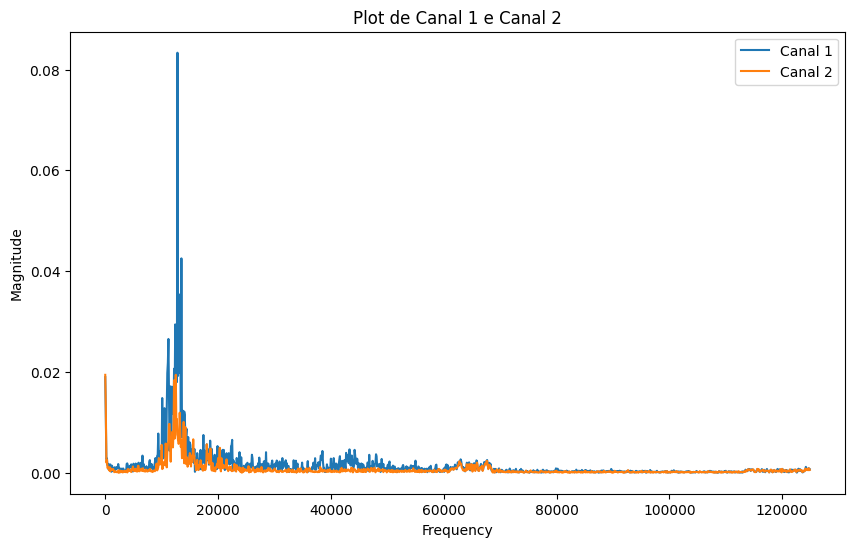

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(xf1, V1_windows_fft['02'][12]['Canal 1'], label='Canal 1')
plt.plot(xf1, V1_windows_fft['02'][12]['Canal 2'], label='Canal 2')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Plot de Canal 1 e Canal 2')
plt.legend()
plt.show()

In [45]:
xf1[150]

15000.0

In [46]:
xf1[700]

70000.0

In [30]:
for posic_sensor in V1_windows_fft:
    for idx, amostra in enumerate(V1_windows_fft[posic_sensor]):
        V1_windows_fft[posic_sensor][idx] = amostra[150:700]
        V1_windows_fft[posic_sensor][idx].reset_index(drop=True,inplace = True)

In [31]:
f0_baixa = 15000
f0_alta = 70000

V0_windows_fft = {}
num_elementos = len(V0_windows['01'])
for i in range(1, 10):
    key = f'{i:02d}'
    V0_windows_fft[key] = [pd.DataFrame(columns=['Canal 1', 'Canal 2']) for _ in range(num_elementos)]

for posic_sensor in V0_windows:
    for idx, amostra in enumerate(V0_windows[posic_sensor]):
        xf1, V0_windows_fft[posic_sensor][idx]['Canal 1'] = FFT(V0_windows[posic_sensor][idx], 'Canal 1', fs, N)
        xf2, V0_windows_fft[posic_sensor][idx]['Canal 2'] = FFT(V0_windows[posic_sensor][idx], 'Canal 2', fs, N)
        V0_windows_fft[posic_sensor][idx].reset_index(drop=True,inplace=True)

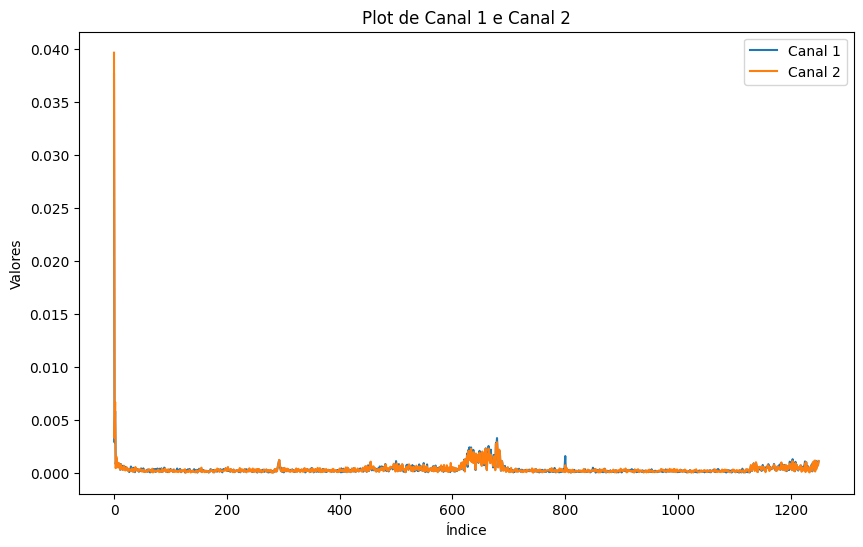

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(V0_windows_fft['07'][10]['Canal 1'], label='Canal 1')
plt.plot(V0_windows_fft['07'][10]['Canal 2'], label='Canal 2')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Plot de Canal 1 e Canal 2')
plt.legend()
plt.show()

In [32]:
for posic_sensor in V0_windows_fft:
    for idx, amostra in enumerate(V0_windows_fft[posic_sensor]):
        V0_windows_fft[posic_sensor][idx] = amostra[150:700]
        V0_windows_fft[posic_sensor][idx].reset_index(drop=True,inplace = True)

In [33]:
V0_windows_fft

{'01': [      Canal 1   Canal 2
  0    0.000114  0.000118
  1    0.000285  0.000159
  2    0.000194  0.000046
  3    0.000157  0.000036
  4    0.000206  0.000089
  ..        ...       ...
  545  0.000037  0.000112
  546  0.000138  0.000138
  547  0.000064  0.000142
  548  0.000343  0.000073
  549  0.000161  0.000081
  
  [550 rows x 2 columns],
        Canal 1   Canal 2
  0    0.000080  0.000287
  1    0.000127  0.000239
  2    0.000200  0.000209
  3    0.000083  0.000142
  4    0.000206  0.000154
  ..        ...       ...
  545  0.000117  0.000084
  546  0.000153  0.000060
  547  0.000097  0.000088
  548  0.000201  0.000210
  549  0.000329  0.000208
  
  [550 rows x 2 columns],
        Canal 1   Canal 2
  0    0.000152  0.000124
  1    0.000217  0.000054
  2    0.000091  0.000296
  3    0.000083  0.000222
  4    0.000150  0.000229
  ..        ...       ...
  545  0.000376  0.000152
  546  0.000134  0.000249
  547  0.000010  0.000043
  548  0.000256  0.000202
  549  0.000193  0.000417


In [54]:
V1_windows_fft

{'01': [      Canal 1   Canal 2
  0    0.006478  0.002296
  1    0.004233  0.014490
  2    0.004484  0.010910
  3    0.001339  0.002128
  4    0.003196  0.002320
  ..        ...       ...
  545  0.000173  0.000503
  546  0.000610  0.000433
  547  0.000592  0.000585
  548  0.000359  0.000378
  549  0.000370  0.000333
  
  [550 rows x 2 columns],
        Canal 1   Canal 2
  0    0.007024  0.011115
  1    0.005183  0.007238
  2    0.002974  0.004904
  3    0.000689  0.001851
  4    0.003056  0.003068
  ..        ...       ...
  545  0.000327  0.000476
  546  0.000289  0.000257
  547  0.000600  0.000919
  548  0.000364  0.000316
  549  0.000346  0.000279
  
  [550 rows x 2 columns],
        Canal 1   Canal 2
  0    0.007877  0.009657
  1    0.003595  0.008835
  2    0.002784  0.006720
  3    0.001877  0.012118
  4    0.002537  0.001384
  ..        ...       ...
  545  0.000819  0.001028
  546  0.000444  0.000100
  547  0.000831  0.000837
  548  0.000178  0.000219
  549  0.000328  0.000293


### MinMax Scaler tanto para V0 quanto para V1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

for key, value_list in V0_windows_fft.items():
    for i, df in enumerate(value_list):
        scaler = MinMaxScaler()

        scaled_values_1 = scaler.fit_transform(df[['Canal 1']])
        scaled_values_2 = scaler.fit_transform(df[['Canal 2']])

        V0_windows_fft[key][i]['Canal 1'] = scaled_values_1.flatten()
        V0_windows_fft[key][i]['Canal 2'] = scaled_values_2.flatten()

In [35]:
from sklearn.preprocessing import MinMaxScaler

for key, value_list in V1_windows_fft.items():
    for i, df in enumerate(value_list):
        scaler = MinMaxScaler()

        scaled_values_1 = scaler.fit_transform(df[['Canal 1']])
        scaled_values_2 = scaler.fit_transform(df[['Canal 2']])

        V1_windows_fft[key][i]['Canal 1'] = scaled_values_1.flatten()
        V1_windows_fft[key][i]['Canal 2'] = scaled_values_2.flatten()

In [36]:
results = []
best_model = None
best_accuracy = 0

In [37]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_model = None
best_accuracy = 0

In [38]:
all_windows = []
labels = []

In [39]:
for key, value in V0_windows_fft.items():
    all_windows.extend(value)
    labels.extend([0] * len(value))

In [40]:
for key, value in V1_windows_fft.items():
    all_windows.extend(value)
    labels.extend([int(key)] * len(value))

In [41]:
X = np.array(all_windows)
y = np.array(labels)

In [47]:
type(X)

numpy.ndarray

In [ ]:
print('tf vers: ', tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [54]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
num_units_list = [64, 128]
drop_list = [0.3]
batch_sizes = [32, 64]
epochs_list = [50, 75]
optimizer_list = ['Adam']
dense_activations = ["relu"]

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import,put, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MultiHeadAttention

def create_model(num_units, dense_activation, drop, optimizer):
    model = Sequential()

    input_layer =input(shape=(len(X[0]), 2))

    layer_1 = MultiHeadAttention(num_heads=2, key_dim=2)(input_layer, input_layer)
    layer_1 = Flatten()(layer_1)

    layer_1 = Dropout(drop)(layer_1)

    layer_2 = Dense(num_units, activation=dense_activation)(layer_1)
    layer_2 = Dropout(drop)(layer_2)

    layer_3 = Dense(num_units//2, activation=dense_activation)(layer_2)
    layer_3 = Dropout(drop)(layer_3)

    output_layer = Dense(10, activation='softmax')(layer_3)
    model = Model(inputs =input_layer, outputs = output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

for num_units in num_units_list:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            for dense_activation in dense_activations:
                for drop in drop_list:
                    for optimizer in optimizer_list:
                        print(f"Training model with {num_units} units, batch size {batch_size}, epochs {epochs}, dense_activation {dense_activation}, dropout {drop}, optimizer {optimizer}...")
                        fold_results = []
                        fold_number = 0
                        accuracy = 0
                        precision = 0
                        recall = 0
                        f1 = 0
                        for train_index, test_index in kf.split(X, y):
                            X_train, X_test = X[train_index], X[test_index]
                            y_train, y_test = y[train_index], y[test_index]
                            y_train_encoded = to_categorical(y_train)
                            y_test_encoded = to_categorical(y_test)

                            model = create_model(num_units, dense_activation, drop, optimizer)
                            history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_encoded), verbose=1)

                            y_pred = np.argmax(model.predict(X_test), axis=-1)

                            new_acc = accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred)
                            accuracy += new_acc

                            new_precision = precision_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            precision += new_precision

                            new_recall = recall_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            recall += new_recall

                            new_f1 = f1_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            f1 += new_f1

                            fold_results.append((new_acc, new_precision, new_recall, new_f1))

                            fold_number += 1

                        if (accuracy/fold_number) > best_accuracy:
                            best_accuracy = accuracy/fold_number
                            best_model = model
                            best_dense_activation = dense_activation
                            best_num_units = num_units
                            best_batch_size = batch_size
                            best_epochs = epochs
                            best_dropout = drop
                            best_optimizer = optimizer

                        results.append((num_units, batch_size, epochs, dense_activation, drop, optimizer, fold_results))

best_results = []
best_results.append((best_accuracy, best_dense_activation, best_num_units, best_batch_size, best_epochs, best_dropout, best_optimizer))
best_results_df = pd.DataFrame(best_results, columns=['best_accuracy', 'best_dense_activation', 'best_num_units', 'best_batch_size', 'best_epochs', 'best_dropout', 'best_optimizer'])
best_results_df.to_csv('./best_results_fft_15k_70k.csv',index=False)

results_df = pd.DataFrame(results, columns=['Num Units', 'Batch Size', 'Epochs', 'Dense Activation', 'drop', 'optimizer', 'Fold Results (accuracy, precision, recall, f1)'])
results_df.to_csv('./all_results_fft_15k_70k.csv',index=False)

best_model.save('./best_model_fft_15k_70k.h5')

Training model with 64 units, batch size 32, epochs 50, dense_activation relu, dropout 0.3, optimizer Adam...
Epoch 1/50
250/250 [==============================] - 6s 15ms/step - loss: 2.2484 - accuracy: 0.1385 - val_loss: 2.1827 - val_accuracy: 0.1725
Epoch 2/50
250/250 [==============================] - 3s 14ms/step - loss: 2.1727 - accuracy: 0.1663 - val_loss: 2.1271 - val_accuracy: 0.2010
Epoch 3/50
250/250 [==============================] - 3s 13ms/step - loss: 2.0644 - accuracy: 0.2082 - val_loss: 1.9209 - val_accuracy: 0.2800
Epoch 4/50
250/250 [==============================] - 3s 12ms/step - loss: 1.8263 - accuracy: 0.3055 - val_loss: 1.5624 - val_accuracy: 0.4030
Epoch 5/50
250/250 [==============================] - 3s 12ms/step - loss: 1.4283 - accuracy: 0.4226 - val_loss: 1.1578 - val_accuracy: 0.5200
Epoch 6/50
250/250 [==============================] - 3s 12ms/step - loss: 1.1746 - accuracy: 0.4986 - val_loss: 0.9351 - val_accuracy: 0.5970
Epoch 7/50
250/250 [============

In [63]:
from keras.models import load_model

model = load_model('best_model_fft_15k_70k.h5')

In [64]:
y_pred = model.predict(X)

313/313 [==============================] - 3s 4ms/step


In [65]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [66]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y, y_pred_classes)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

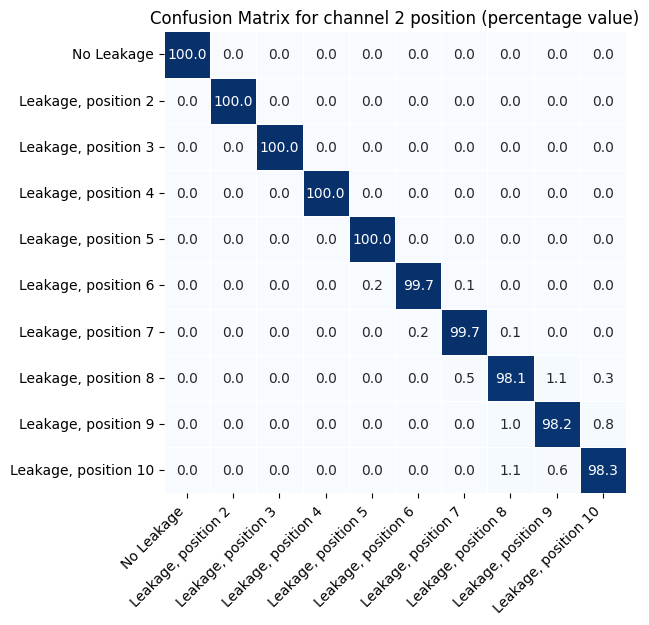

In [67]:
import seaborn as sns
class_labels = ['No Leakage', 'Leakage, position 2', 'Leakage, position 3', 'Leakage, position 4', 'Leakage, position 5', 'Leakage, position 6', 'Leakage, position 7', 'Leakage, position 8', 'Leakage, position 9', 'Leakage, position 10']
conf_matrix_df = pd.DataFrame(conf_matrix_percent, index=class_labels, columns=class_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='.1f', cbar=False, square=True, linewidths=0.5)

# Rotate x-axis labels by 45 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

plt.title('Confusion Matrix for channel 2 position (percentage value)')
plt.show()

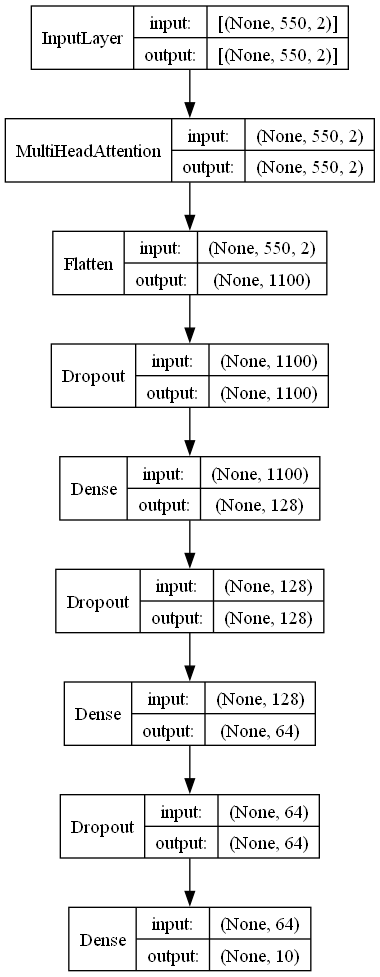

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='./arquitetura_do_modelo.png', show_shapes=True, show_layer_names=False)

In [61]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

df = pd.read_csv('all_results_fft_15k_70k.csv')

In [62]:
df

Num Units  Batch Size  Epochs Dense Activation  drop optimizer  \
0         64          32      50             relu   0.3      Adam   
1         64          32      75             relu   0.3      Adam   
2         64          64      50             relu   0.3      Adam   
3         64          64      75             relu   0.3      Adam   
4        128          32      50             relu   0.3      Adam   
5        128          32      75             relu   0.3      Adam   
6        128          64      50             relu   0.3      Adam   
7        128          64      75             relu   0.3      Adam   

      Fold Results (accuracy, precision, recall, f1)  
0  [(0.9655, 0.9657867776603898, 0.9655, 0.965559...  
1  [(0.983, 0.9833467327424776, 0.983, 0.98303482...  
2  [(0.9535, 0.9559178785973773, 0.9535, 0.953560...  
3  [(0.9675, 0.9677993741634808, 0.9675, 0.967568...  
4  [(0.9535, 0.9539321395628569, 0.9535, 0.953464...  
5  [(0.9605, 0.9616547380984771, 0.9605, 0.960409...  
6  [(0.963, 0.9638085256572771, 0.963, 0.96270996...  
7  [(0.961, 0.9622114917055902, 0.961, 0.96114044...

In [63]:
eval(df['Fold Results (accuracy, precision, recall, f1)'][0])

[(0.9655, 0.9657867776603898, 0.9655, 0.9655592027192825),
 (0.9385, 0.9413237939006722, 0.9385, 0.9389546290886183),
 (0.9295, 0.9319893327246749, 0.9295, 0.9287202544742795),
 (0.9795, 0.9813073182492419, 0.9795, 0.9796839759652038),
 (0.9514757378689345, 0.951831119131783, 0.9514757378689345, 0.95142961065838)]

In [65]:
metrics = []
for item in df['Fold Results (accuracy, precision, recall, f1)']:
    metrics.append(eval(item))

In [67]:
metrics_means = []
n_folds = 5

for metric in metrics:
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    for metric_ in metric:
        accuracy = accuracy + metric_[0]
        precision = precision + metric_[1]
        recall = recall + metric_[2]
        f1 = f1 + metric_[3]
    metrics_means.append({'acc': accuracy/n_folds, 'precision': precision/n_folds, 'recall': recall/n_folds, 'f1': f1/n_folds})

In [68]:
metrics_means

[{'acc': 0.9528951475737868,
  'precision': 0.9544476683333525,
  'recall': 0.9528951475737868,
  'f1': 0.952869534581153},
 {'acc': 0.9559911955977988,
  'precision': 0.9590180962800987,
  'recall': 0.9559911955977988,
  'f1': 0.9556337211710882},
 {'acc': 0.9325944472236118,
  'precision': 0.9337020931153784,
  'recall': 0.9325944472236118,
  'f1': 0.9303541707881327},
 {'acc': 0.9514957978989494,
  'precision': 0.9542929619758193,
  'recall': 0.9514957978989494,
  'f1': 0.950191430893631},
 {'acc': 0.9631966983491747,
  'precision': 0.963749584563727,
  'recall': 0.9631966983491747,
  'f1': 0.9631590758812786},
 {'acc': 0.9734969984992496,
  'precision': 0.9738379872829948,
  'recall': 0.9734969984992496,
  'f1': 0.9734688212688114},
 {'acc': 0.952495947973987,
  'precision': 0.9536821089903125,
  'recall': 0.952495947973987,
  'f1': 0.952090766481619},
 {'acc': 0.9628985492746374,
  'precision': 0.9642012213168248,
  'recall': 0.9628985492746374,
  'f1': 0.9629043817122189}]

In [70]:
df_new = df.copy()
df_new.drop(columns='Fold Results (accuracy, precision, recall, f1)', inplace=True)

In [71]:
acc_list = []
prec_list = []
recall_list = []
f1_list = []
for idx, item in enumerate(metrics_means):
    acc_list.append(item['acc'])
    prec_list.append(item['precision'])
    recall_list.append(item['recall'])
    f1_list.append(item['f1'])

In [72]:
acc_column = pd.Series(acc_list)
prec_column = pd.Series(prec_list)
recall_column = pd.Series(recall_list)
f1_column = pd.Series(f1_list)

In [73]:
df_new['Accuracy'] = acc_column
df_new['Precision'] = prec_column
df_new['Recall'] = recall_column
df_new['F1'] = f1_column

In [74]:
df = df_new

In [75]:
columns = ['Num Units', 'Batch Size', 'Epochs', 'Accuracy', 'Precision', 'Recall', 'F1']
df = df[columns]

In [76]:
df

Num Units  Batch Size  Epochs  Accuracy  Precision    Recall        F1
0         64          32      50  0.952895   0.954448  0.952895  0.952870
1         64          32      75  0.955991   0.959018  0.955991  0.955634
2         64          64      50  0.932594   0.933702  0.932594  0.930354
3         64          64      75  0.951496   0.954293  0.951496  0.950191
4        128          32      50  0.963197   0.963750  0.963197  0.963159
5        128          32      75  0.973497   0.973838  0.973497  0.973469
6        128          64      50  0.952496   0.953682  0.952496  0.952091
7        128          64      75  0.962899   0.964201  0.962899  0.962904

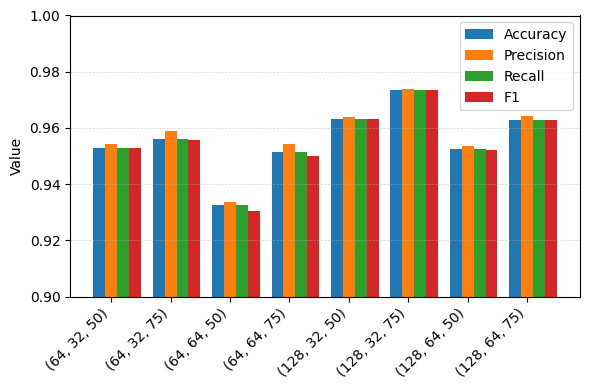

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

bar_width = 0.2

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    plt.bar(df.index + i * bar_width, df[metric], width=bar_width, label=metric)

plt.ylabel('Value')
plt.xticks(df.index + bar_width, ['({}, {}, {})'.format(nu, bs, e) for nu, bs, e in zip(df['Num Units'], df['Batch Size'], df['Epochs'])], rotation=45, ha='right')
plt.legend()

plt.ylim(0.9, 1)

plt.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()
